In [1]:
!pip install fastbook fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [15]:
import os
from pathlib import Path
from fastbook import search_images_bing,get_image_files,verify_images
from fastai.vision.utils import download_images
import shutil
from fastai.vision.learner import vision_learner
from fastbook import get_image_files
from fastai.data.transforms import parent_label,RandomSplitter
from fastai.data.block import DataBlock,CategoryBlock
from fastai.vision.data import ImageBlock
from fastai.vision.augment import Resize,RandomResizedCrop
from torchvision.models.resnet import resnet18
from fastai.metrics import error_rate
from fastai.vision.augment import ResizeMethod,aug_transforms
from fastai.interpret import ClassificationInterpretation

In [4]:
plant_types = 'basil','thyme','weed'
path = Path('plants')

In [5]:
if path.exists():
    shutil.rmtree(path)

path.mkdir()
for o in plant_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} plant')
    print(f"Obtained {len(results)} results for {o}")
    download_images(dest, urls=results.attrgot('contentUrl'))

Obtained 150 results for basil
Obtained 150 results for thyme
Obtained 150 results for weed


In [6]:
fns = get_image_files(path)
failed = verify_images(fns)

In [7]:
failed.map(Path.unlink)

(#12) [None,None,None,None,None,None,None,None,None,None...]

In [10]:
datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [11]:
dls = datablock.dataloaders(path)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.568822,0.873941,0.292683,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.634869,0.331518,0.121951,00:36
1,0.492619,0.241696,0.085366,00:35
2,0.410734,0.274829,0.073171,00:35
3,0.324310,0.273888,0.073171,00:35


In [12]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.126138,0.318208,0.097561,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.085992,0.316248,0.097561,00:35
1,0.086909,0.304362,0.073171,00:37
2,0.081371,0.402000,0.097561,00:35
3,0.079332,0.502856,0.097561,00:37
4,0.070947,0.488597,0.085366,00:37
5,0.066955,0.491949,0.085366,00:36
6,0.060560,0.509702,0.097561,00:37
7,0.054276,0.507880,0.097561,00:35
8,0.047642,0.510522,0.085366,00:37
9,0.044656,0.513718,0.085366,00:35


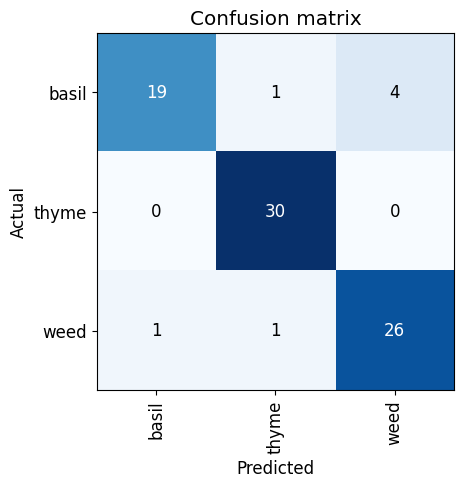

In [14]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

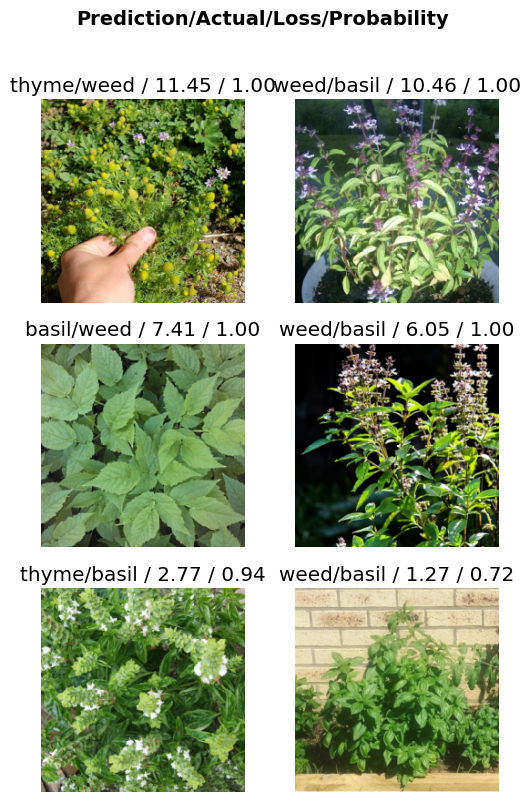

In [18]:
interp.plot_top_losses(6, nrows=3)

In [20]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner